## Preamble: Libs + signal def

In [1]:
import itertools, importlib, sys, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
warnings.filterwarnings("ignore")

sys.path.append('./embodied_arch')

import embodied as emg
import embodied_indep as emi 

%matplotlib inline
plt.rcParams['figure.figsize'] = (18,7)

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/train_rf_flugame_worker'

importlib.reload(emg)
importlib.reload(emi)

#sys.path.append('./flumodel_python')

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Default Behavioral Model

In [2]:
import flumodel_python.flu_env_basic as FABM

In [3]:
importlib.reload(FABM)

# Verify class signature ##??FABM
?FABM.Flu_ABM

Init signature: FABM.Flu_ABM(model_path='./', output_file=None)
Docstring:     
A class that re-creates the Flu ABM environment.
Standard Behavioral Model only

Constructor Parameters:...
File:           ~/Documents/RAND/Coding/multiagent-ABM/flumodel_python/flu_env_basic.py
Type:           type
Subclasses:     


In [4]:
# cd flumodel_python/
flu = FABM.Flu_ABM(model_path="./flumodel_python/")
flu.popn.head(10)

,Person.ID,Household.ID,Age,Gender,Worker,net.degree,age.group,income,Head,Guardian.ID,...,immunized,susc,inf,symptomatic,severe,niILI,think.flu,antivirals,antivirals.help,BM
0,2000261,2000076,57,F,0.0,7.0,7,13,True,nan,...,0,0,0,0,0,0,0,0,0,Default
1,2000262,2000076,23,M,1.0,39.0,3,13,False,nan,...,0,0,0,0,0,0,0,0,0,Default
2,2000263,2000076,32,M,1.0,32.0,4,13,False,nan,...,0,0,0,0,0,0,0,0,0,Default
3,2000264,2000076,26,F,1.0,70.0,4,13,False,nan,...,0,0,0,0,0,0,0,0,0,Default
4,2000260,2000076,58,M,1.0,33.0,7,13,False,nan,...,0,0,0,0,0,0,0,0,0,Default
5,2000413,2000122,36,F,0.0,4.0,5,11,True,nan,...,0,0,0,0,0,0,0,0,0,Default
6,2000414,2000122,6,F,0.0,6.0,2,11,False,2000413.0,...,0,0,0,0,0,0,0,0,0,Default
7,2000415,2000122,2,M,0.0,32.0,1,11,False,2000413.0,...,0,0,0,0,0,0,0,0,0,Default
8,2000416,2000122,0,M,0.0,28.0,1,11,False,2000413.0,...,0,0,0,0,0,0,0,0,0,Default
9,2000412,2000122,36,M,1.0,55.0,5,11,False,nan,...,0,0,0,0,0,0,0,0,0,Default


In [5]:
infected=(flu.stepAll())

### RL ABM Env

In [5]:
import flumodel_python.flu_env as Fenv

In [7]:
importlib.reload(Fenv)

?Fenv.Flu_env

Init signature: Fenv.Flu_env(exo_idx=0, model_path='./')
Docstring:     
A class that re-creates the multi-agent Flu ABM environment.
Handles the following cases:
    - (N-1) non-RL agents interacting with 1 RL agent (the N^{th});
    - (N-k) non-RL agents interacting with k RL agent (the N^{th}).
Uses Pandas referencing to make sure the selection works for single and multiple agents

Constructor Parameters:
    exo_idx: reference index for agent in population that will take RL decision-module.
        - scalar or index list (all values must be within popn index range)
    model_path: dir location of req'd ABM parameterization files.

Considerations:
    self.state: the ABM's DF uses boolean state variables.
        Recasting as floats for RL state-inputs...
Init docstring:
RL Flu ABM environment specification.
:param exo_idx: List of indices of RL-agents in the population
:param model_path: folder spec for location of ABM files.
File:           ~/Documents/RAND/Coding/multiagent-ABM/f

## Single Agent Setup

In [ ]:
importlib.reload(emg)

In [ ]:
tf.reset_default_graph()
flu_env = Fenv.Flu_env(exo_idx=1,
                          model_path="./flumodel_python/")

# flu_env.popn.columns

In [ ]:
flu_env.rl_idx

In [ ]:
flu_env.popn[Fenv._state_lbls_].iloc[flu_env.rl_idx]

In [ ]:
print(Fenv._state_lbls_)
flu_env.popn[Fenv._state_lbls_].iloc[[1,2,3,4]].values

In [ ]:
num_episodes, n_epochs, max_len = (5, 4, 5)

flurf = emg.EmbodiedAgentRF(
    name="fluRF",
    env_=flu_env,
    alpha=1.,
    max_episode_length=max_len
)

# flurf = emg.EmbodiedAgentAC(
#     name="fluAC",
#     env_=flu_env,
#     max_episode_length=max_len, latentDim=4, 
#     alpha_p=1., alpha_v=1e-2, 
#     actorNN=actor, sensorium=sensor, valueNN=value
# )

print(flurf, flurf.s_size, flurf.a_size)

In [ ]:
print(flu_env.state_space_size, flu_env.action_space_size)

In [ ]:
sess = tf.InteractiveSession()
flurf.init_graph(sess) # note tboard log dir

In [ ]:
## Verify step + play set up
state = flurf.env.reset()

In [ ]:
print(state, flurf.act(state, sess))

In [ ]:
flurf.env.step(flurf.act(state, sess))

In [ ]:
flu_env.popn[Fenv._state_lbls_].iloc[flu_env.rl_idx]

In [ ]:
flurf.play(sess)

In [ ]:
print(flurf.last_total_return)

In [ ]:
flu_env.popn[Fenv._state_lbls_].iloc[flu_env.rl_idx]

In [ ]:
hist1 = flurf.work(sess, num_epochs=n_epochs, saver=saver)

In [ ]:
hist1

## Multiple Agent Setup

In [6]:
import embodied_indep as emi 
from embodied_misc import ActionPolicyNetwork, SensoriumNetworkTemplate, ValueNetwork

In [7]:
# importlib.reload(Fenv)
importlib.reload(emi)

<module 'embodied_indep' from './embodied_arch/embodied_indep.py'>

### MARL Env Setup

In [8]:
exos = [1,2,3,10]  # (np.random.sample(9223) < 0.3)
# exos = 3707

importlib.reload(Fenv);
# importlib.reload(emg);
importlib.reload(emi);

In [9]:
tf.reset_default_graph()
flu_menv = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

In [10]:
print(flu_menv.actor_count)
print(flu_menv.state_space_size, flu_menv.action_space_size)

4
8 1


In [11]:
?flu.stepAll

Signature: flu.stepAll()
Docstring:
Steps the game 1 step forward in time for all players using default behavioral model.
Returns:
    r_t: infection outcomes
File:      ~/Documents/RAND/Coding/multiagent-ABM/flumodel_python/flu_env_basic.py
Type:      method


In [26]:
infected=np.array(flu.stepAll(), dtype=float)
print(len(infected), sum(infected))
infected[exos]

9223 306.0


array([1., 0., 0., 0.])

In [27]:
num_episodes, max_len, n_epochs, evry = (100, 35, 1501, 300)

In [28]:
for _ in range(150):
    infxd=np.array(flu.stepAll(), dtype=float)

infxd = []
for k in range(num_episodes):
    infxd.append(np.array(flu.stepAll(), dtype=float))

infected = np.array(infxd)
print(infected.shape, np.mean(infected, axis=0))

In [32]:
len(np.mean(infected, axis=1))

100

(array([4.390e+03, 2.349e+03, 1.259e+03, 6.470e+02, 2.750e+02, 1.530e+02,
        1.000e+02, 3.100e+01, 1.600e+01, 3.000e+00]),
 array([0.   , 0.041, 0.082, 0.123, 0.164, 0.205, 0.246, 0.287, 0.328,
        0.369, 0.41 ]),
 <a list of 10 Patch objects>)

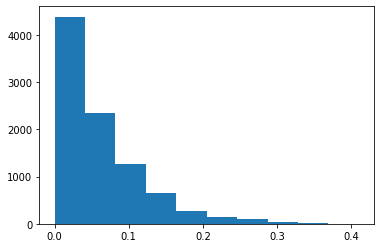

In [30]:
plt.hist(np.mean(infected, axis=0))

In [35]:
exos

[1, 2, 3, 10]

In [41]:
np.mean(infected[exos], axis=1)

array([0.10094329, 0.05887455, 0.12132712, 0.02786512])

In [43]:
infected[:,exos].shape

(100, 4)

### MARL Learner Demo

In [13]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,8), out_dim=out_dim, gamma_reg=5.)

# num_episodes, n_epochs, max_len = (100, 1501, 15)
# num_episodes, n_epochs, max_len = (10, 400, 25)
num_episodes, n_epochs, max_len = (5, 4, 5)

In [14]:
flumrf = emi.EmbodiedAgent_IRFB(name="flu_mRFB",
                                env_=flu_menv,
                                alpha_p=5.0e2, alpha_v=50.,
                                max_episode_length=max_len,
                                latentDim=8, _every_=300,
                                actorNN=actor, valueNN=value, sensorium=sensor
                               )

print(flumrf.actor_names)
(flumrf.a_size, flumrf.env.action_space_size)

(1, 1)

In [17]:
sess = tf.InteractiveSession()
flumrf.init_graph(sess) # note tboard log dir
saver = tf.train.Saver(max_to_keep=1) 

Tensorboard logs in:  ./log/train_flu_mRFB


In [18]:
hist = flumrf.work(sess, num_epochs=n_epochs, saver=saver)

Starting agent flu_mRFB
Epoch no.: 0/4

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (4.0, 4.5, 5.0)
Losses/Policy LLs: (-1.9893926, -0.5490697, -0.14472237)
Losses/Critic Scores: (-0.16429698, 0.8118602, 1.9892905)
Losses/Policy Entropies: (0.3952943, 0.53391814, 0.6503774)
Saved Model
Epoch no.: 3/4

In [19]:
hist

array([[4.  , 4.5 , 5.  ],
       [3.  , 4.  , 5.  ],
       [4.  , 4.75, 5.  ],
       [4.  , 4.75, 5.  ]])